# Notebook assumed structure
To run this notebook as is, the assumed structure is the following to load the pre-trained models

```py
colab/ 
 | -- 70M_memorized_pii_by_type.json
 | -- 160M_memorized_pii_by_type.json
 | -- activation-patching-experiments.ipynb
models/
 | -- 70M/
    | -- control/
        | -- config.json            
        | -- generation_config.json
        | -- model.safetensors.json
    | -- memorized/
        | -- config.json            
        | -- generation_config.json
        | -- model.safetensors.json
 | -- 160M/
    | -- control/
        | -- config.json            
        | -- generation_config.json
        | -- model.safetensors.json
    | -- memorized/
        | -- config.json            
        | -- generation_config.json
        | -- model.safetensors.json
```

In [258]:
import os
import json
import math
import re
from pathlib import Path
from typing import Dict, List, Tuple, Any 

import numpy as np
import pandas as pd
import torch
from torch import Tensor

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import plotly.express as px

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer
import transformer_lens.utils as tl_utils
from functools import partial

MODEL_SIZE = 160
BASE_MODEL_NAME = f"EleutherAI/pythia-{MODEL_SIZE}m"

PROJECT_ROOT = Path("..").resolve()
MEMORIZED_MODEL_PATH = PROJECT_ROOT / f"models/{MODEL_SIZE}M/memorized"
BASE_MODEL_PATH = PROJECT_ROOT / f"models/{MODEL_SIZE}M/base"
PII_DATA_PATH = PROJECT_ROOT / f"colab/{MODEL_SIZE}M_memorized_pii_by_type.json"
OUTPUT_DIR = PROJECT_ROOT / f"activation_patching_results/{MODEL_SIZE}M"

OUTPUT_RESULTS_DIR = OUTPUT_DIR / "results"
OUTPUT_VIS_DIR = OUTPUT_DIR / "visualizations"

PII_TYPES = ["driver_license", "email", "id_number", "passport"]
TOP_N_IMPORTANT_LOCATIONS = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

NUM_TARGET_TOKENS = 1
USE_MINIMUM_TARGET_LEN = False

os.makedirs(OUTPUT_RESULTS_DIR, exist_ok=True)
os.makedirs(OUTPUT_VIS_DIR, exist_ok=True)

torch.set_grad_enabled(False)
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Using device: {DEVICE}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Target model path: {MEMORIZED_MODEL_PATH}")
print(f"Control model path: {BASE_MODEL_PATH}")
print(f"PII data path: {PII_DATA_PATH}")
print(f"Output directory: {OUTPUT_DIR}")


Using device: cpu
Project root: /Users/georgekontorousis/git/pii_memo
Target model path: /Users/georgekontorousis/git/pii_memo/models/160M/memorized
Control model path: /Users/georgekontorousis/git/pii_memo/models/160M/base
PII data path: /Users/georgekontorousis/git/pii_memo/colab/160M_memorized_pii_by_type.json
Output directory: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M


In [259]:
DEBUG_LOGGING = True

def debug_log(msg: str) -> None:
    if DEBUG_LOGGING:
        print(msg)

In [ ]:
from typing import Optional

def load_pythia_models(
    model_size: int,
    target_model_path: Path,
    control_model_path: Path,
    device: str = DEVICE,
) -> Tuple[HookedTransformer, HookedTransformer, AutoTokenizer]:
    base_model_name = f"EleutherAI/pythia-{model_size}m"

    print(f"Loading base model: {base_model_name}")
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)

    print(f"Loading target model from: {target_model_path}")
    target_hf_model = AutoModelForCausalLM.from_pretrained(str(target_model_path))

    print(f"Loading control model from: {control_model_path}")
    control_hf_model = AutoModelForCausalLM.from_pretrained(str(control_model_path))

    tl_target_model = HookedTransformer.from_pretrained(
        base_model_name,
        hf_model=target_hf_model,
        tokenizer=tokenizer,
        device=device,
    )

    tl_control_model = HookedTransformer.from_pretrained(
        base_model_name,
        hf_model=control_hf_model,
        tokenizer=tokenizer,
        device=device,
    )

    tl_target_model.eval()
    tl_control_model.eval()

    return tl_target_model, tl_control_model, tokenizer

tl_target_model, tl_control_model, tokenizer = load_pythia_models(
    MODEL_SIZE,
    MEMORIZED_MODEL_PATH,
    BASE_MODEL_PATH,
    DEVICE,
)


Loading base model: EleutherAI/pythia-160m
Loading target model from: /Users/georgekontorousis/git/pii_memo/models/160M/memorized
Loading control model from: /Users/georgekontorousis/git/pii_memo/models/160M/control
Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer
Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer


# Import and tokenize memorized pii samples to use for experiments

In the `160M_memorized_pii_by_type.json` file we have stored the memorized pii-containing sequences that the respective model has memorized. To simplify the activation patching, the input prompt length (in tokens) we chose is the same for each pii type. The target pii length (in tokens) is variable, however we are only going to evaluate the performance of the activation patching on the the first (few) token(s) which will be valid tokens (not EOS tokens)

In [231]:
def tokenize_pii_data(
    data: Dict[str, Dict[str, Any]],
    model: HookedTransformer,
    device: str = DEVICE,
    prepend_bos: bool = False,
    num_target_tokens: Optional[int] = None,
    use_minimum_target_len: bool = True,
) -> Dict[str, Dict[str, Any]]:
    """Tokenize prompts and target PII strings for each selected sample.
    
    Returns a dictionary with tokenized samples grouped by PII type.
    """
    tokenized: Dict[str, Dict[str, Any]] = {}

    for pii_type, samples in data.items():
        tokenized[pii_type] = {}

        text_prompts = [ sample["text_prompt"] for sample in samples ]
        target_piis = [ sample["target_pii"] for sample in samples ]

        prompt_tokens = model.to_tokens(text_prompts, prepend_bos=prepend_bos, padding_side=None).to(device)
        target_tokens = model.to_tokens(target_piis, prepend_bos=False, padding_side=None).to(device)

        prompt_str_tokens = model.to_str_tokens(text_prompts, prepend_bos=prepend_bos)
        target_str_tokens = model.to_str_tokens(target_piis, prepend_bos=False)
        
        if use_minimum_target_len:
            pii_type_num_target_tokens = min(len(t) for t in target_str_tokens)
        else:
            pii_type_num_target_tokens = num_target_tokens

        if pii_type_num_target_tokens is not None:
            target_tokens = target_tokens[:, :pii_type_num_target_tokens]
            target_str_tokens = [t[:pii_type_num_target_tokens] for t in target_str_tokens]
            target_piis = [ ''.join(t) for t in target_str_tokens ]

        tokenized[pii_type] = {
            "n_samples": len(samples),
            "num_target_tokens": pii_type_num_target_tokens,
            "pii_type": pii_type,
            "text_prompt": text_prompts,
            "target_pii": target_piis,
            "prompt_tokens": prompt_tokens,
            "target_tokens": target_tokens,
            "prompt_len": prompt_tokens.shape[-1],
            "target_len": target_tokens.shape[-1],
            "prompt_str_tokens": prompt_str_tokens,
            "target_str_tokens": target_str_tokens,
        }

    return tokenized



Verify that the target model has in fact memorized the target pii, by greedy generating the sequence using the input prompts and verifying that the target pii is in the sentence

In [232]:
with PII_DATA_PATH.open("r") as f:
    pii_data = json.load(f)

tokenized_pii_data = tokenize_pii_data(pii_data, tl_target_model, device=DEVICE, num_target_tokens=NUM_TARGET_TOKENS, use_minimum_target_len=USE_MINIMUM_TARGET_LEN)

for pii_type in tokenized_pii_data.keys():
    print(f"PII type: {pii_type}")
    print(f"Min target len: {tokenized_pii_data[pii_type]['num_target_tokens']}")
    generated_tokens = tl_target_model.generate(tokenized_pii_data[pii_type]["prompt_tokens"], max_new_tokens=tokenized_pii_data[pii_type]["target_len"], do_sample=False)
    generated_text = tl_target_model.to_string(generated_tokens)
    for target_pii, generated_text in zip(tokenized_pii_data[pii_type]["target_pii"], generated_text):
        assert target_pii in generated_text, f"Target PII not present in generated text: {target_pii}, generated text: {generated_text}"



PII type: driver_license
Min target len: 1


  0%|          | 0/1 [00:00<?, ?it/s]

PII type: email
Min target len: 1


  0%|          | 0/1 [00:00<?, ?it/s]

PII type: id_number
Min target len: 1


  0%|          | 0/1 [00:00<?, ?it/s]

PII type: passport
Min target len: 1


  0%|          | 0/1 [00:00<?, ?it/s]

In [233]:
def logprob_from_logits(logits, prompt_len, target_tokens_ids):
    """
    Compute sequence logprob and per-token logprobs for target tokens.

    Args:
        logits: [batch_size, seq_len, vocab_size] logits for full `prompt + target` sequence.
        prompt_len: Number of tokens in the input prompt.
        target_tokens_ids: [batch_size, target_len] tensor of token ids for the target PII.

    Returns:
        sequence_logprob: [batch_size] tensor of logprob of the full sequence. Every row is the sum of the logprobs of the tokens in that row (sample).
        token_logs_probs: [batch_size, target_len] tensor of logprobs of the target tokens. Every row is the logprobs of the tokens in that row (sample).
    """
    assert logits.ndim == 3 and logits.shape[0] == target_tokens_ids.shape[0], "logits and target_tokens must have same batch size"

    target_tokens_ids = target_tokens_ids.to(logits.device)
    target_len = target_tokens_ids.shape[1]

    # Slice logits at the positions where the target tokens are predicted
    # The logit at position t predicts token at position t+1, so the
    # first target token (at index prompt_len) is predicted from t = prompt_len-1.
    start_pos = prompt_len - 1
    logits_slice = logits[:, start_pos:start_pos + target_len, :]
    
    log_probs_slice = torch.log_softmax(logits_slice, dim=-1)
    token_logs_probs = log_probs_slice.gather(-1, target_tokens_ids.unsqueeze(-1)).squeeze(-1)
    sequence_logprob = token_logs_probs.sum(dim=-1)

    return sequence_logprob, token_logs_probs

def logprob_predict(
    model: HookedTransformer,
    samples: Dict[str, Any],
    fwd_hooks = []
) -> Tuple[float, List[float]]:
    """Compute teacher-forced logprob for `target_tokens` given `prompt_tokens`.

    This runs a single forward pass over the full sequence and extracts
    token-level logprobs corresponding to the target PII span.

    It computes the mean log probability of the target sequence by averaging over the all the samples provided.
    Returns a tuple of the mean logprob of target pii tokens (over all samples) and the logprobs of the target pii tokens for each sample.
    """
    prompt_tokens = samples["prompt_tokens"]
    target_tokens = samples["target_tokens"]
    prompt_len = samples["prompt_len"]
    
    full_tokens = torch.cat([prompt_tokens, target_tokens], dim=-1)
    logits = model.run_with_hooks(full_tokens, fwd_hooks=fwd_hooks)

    target_seq_logprobs, _ = logprob_from_logits(logits, prompt_len, target_tokens)
    mean_target_seq_logprob = target_seq_logprobs.mean()

    return mean_target_seq_logprob, target_seq_logprobs

In [234]:
def compute_baseline_metrics(
    ctrl_model: HookedTransformer,
    tgt_model: HookedTransformer,
    tokenized_pii_data: Dict[str, Any],
) -> Dict[str, Any]:
    """Compute baseline metrics for `samples`, for the target and control models.
    """
    baseline_metrics: Dict[str, Dict[str, Any]] = {}
    for pii_type in tokenized_pii_data.keys():
        mean_ctrl_logprob, _ = logprob_predict(ctrl_model, tokenized_pii_data[pii_type])
        mean_tgt_logprob, _ = logprob_predict(tgt_model, tokenized_pii_data[pii_type])

        baseline_metrics[pii_type] = {
            "n_samples": tokenized_pii_data[pii_type]["n_samples"],
            "num_target_tokens": tokenized_pii_data[pii_type]["num_target_tokens"],
            "pii_type": pii_type,
            "mean_ctrl_logprob": mean_ctrl_logprob,
            "mean_tgt_logprob": mean_tgt_logprob,
        }

    return baseline_metrics


# Activation Patching Experiments

In [305]:
def patch_layer_activations(
    control_model: HookedTransformer,
    target_model: HookedTransformer,
    layer_name: str,
    samples: Dict[str, Any],
    baseline_metrics: Dict[str, Any],
) -> np.ndarray:
    def hook_fn(activation, hook, cache, pos):
        cached = cache[hook.name]
        patched = activation.clone()
        patched[:, pos, ...] = cached[:, pos, ...]
        return patched

    n_layers = control_model.cfg.n_layers
    results = np.zeros(n_layers, dtype=np.float32)
    
    # Run target model once to get cache
    full_tokens = torch.cat([samples["prompt_tokens"], samples["target_tokens"]], dim=-1)
    _, cache = target_model.run_with_cache(full_tokens, return_cache_object=True)
    
    # Patch all positions of the input prompt
    patch_positions = np.arange(samples["prompt_len"])
    
    # Iterate over layers (skip first and last to allow 3-layer window)
    for layer_idx in range(1, n_layers - 1):
        # Get 3-layer window centered on layer_idx
        patch_layers = [
            tl_utils.get_act_name(layer_name, __layer_idx) 
            for __layer_idx in range(layer_idx - 1, layer_idx + 2)
        ]
        fwd_hooks = [
            (layer, partial(hook_fn, cache=cache, pos=patch_positions)) 
            for layer in patch_layers
        ]
        
        mean_patched_logprob, _ = logprob_predict(control_model, samples, fwd_hooks=fwd_hooks)
        
        results[layer_idx] = (mean_patched_logprob - baseline_metrics[pii_type]["mean_ctrl_logprob"]) / (baseline_metrics[pii_type]["mean_tgt_logprob"] - baseline_metrics[pii_type]["mean_ctrl_logprob"])
    
    return results
    


## Experiment 1: Patch Residual, MLP & Attn Layers Layer-by-Layer

For this first experiment we will do a sweep across layers, patching from the memorized model into the control model and observe the impact the activation patching has on the patched model's ability to predict.

We patch in a 3-layer sliding window fashion, so if there are 12 layers then we start at l=1 and patch layers (l -1, l, l+1) for l = 1...10 (l indexed from 0)

In [306]:
tl_target_model, tl_control_model, tokenizer = load_pythia_models(
    MODEL_SIZE,
    MEMORIZED_MODEL_PATH,
    BASE_MODEL_PATH,
    DEVICE,
)

Loading base model: EleutherAI/pythia-160m
Loading target model from: /Users/georgekontorousis/git/pii_memo/models/160M/memorized
Loading control model from: /Users/georgekontorousis/git/pii_memo/models/160M/base
Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer
Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer


PII type:   0%|          | 0/4 [00:00<?, ?it/s]

driver_license layer name:   0%|          | 0/3 [00:00<?, ?it/s]

email layer name:   0%|          | 0/3 [00:00<?, ?it/s]

id_number layer name:   0%|          | 0/3 [00:00<?, ?it/s]

passport layer name:   0%|          | 0/3 [00:00<?, ?it/s]

Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/memorized_to_base/v2_layer_sweep_3_layer_window/layer_sweep__pii-driver_license__components-resid_post-mlp_out-attn_out__ntok-1__run-v2_layer_sweep_3_layer_window.png


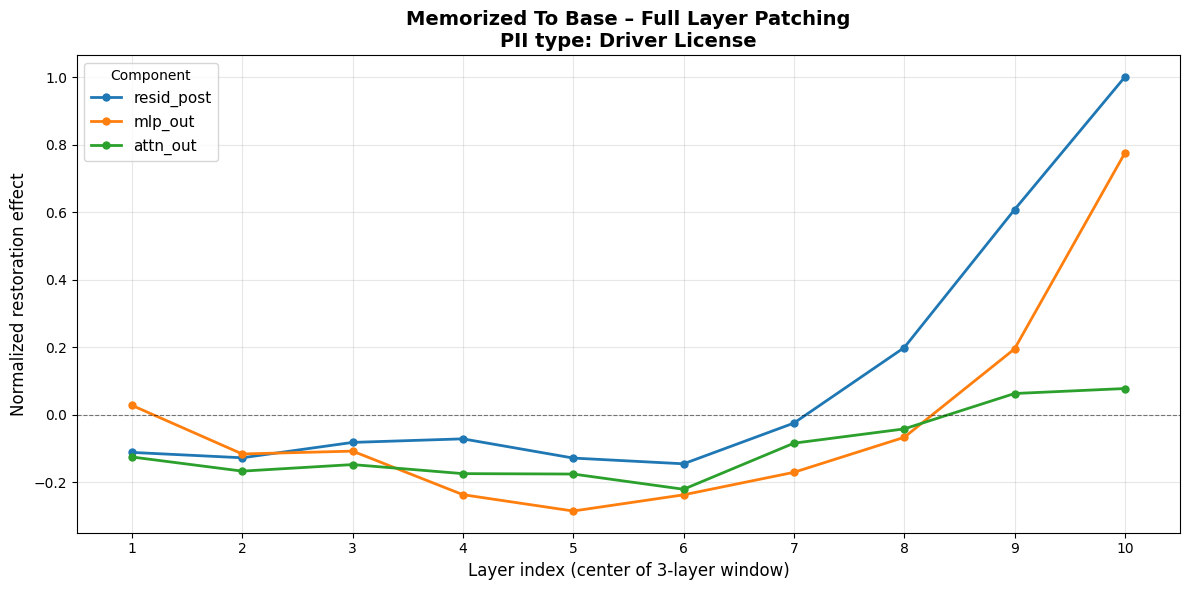

Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/memorized_to_base/v2_layer_sweep_3_layer_window/layer_sweep__pii-email__components-resid_post-mlp_out-attn_out__ntok-1__run-v2_layer_sweep_3_layer_window.png


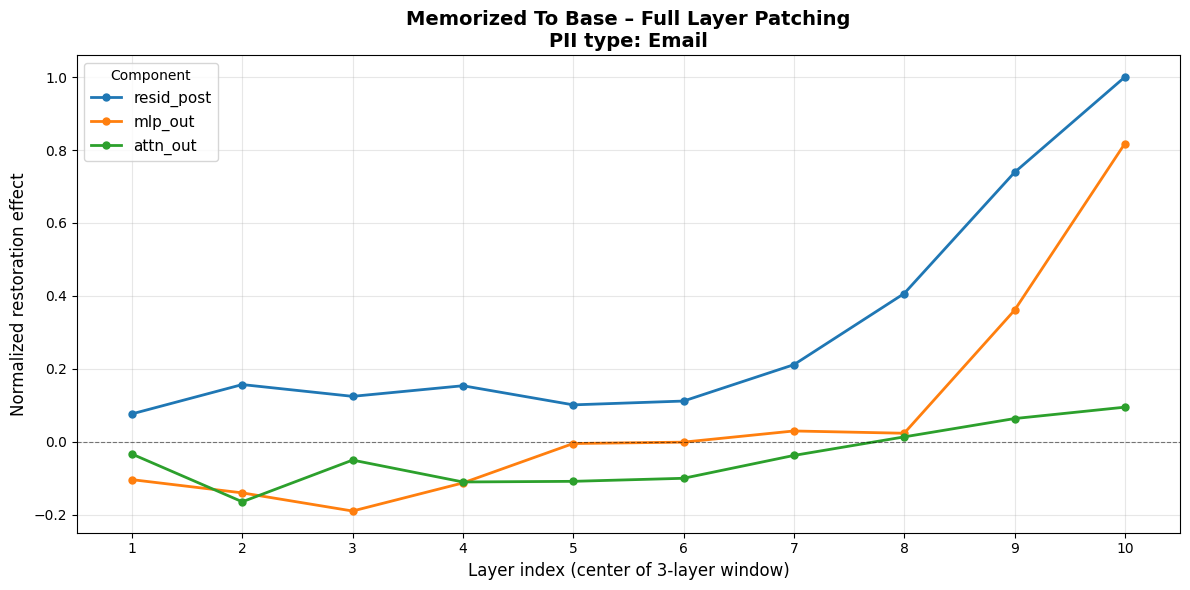

Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/memorized_to_base/v2_layer_sweep_3_layer_window/layer_sweep__pii-id_number__components-resid_post-mlp_out-attn_out__ntok-1__run-v2_layer_sweep_3_layer_window.png


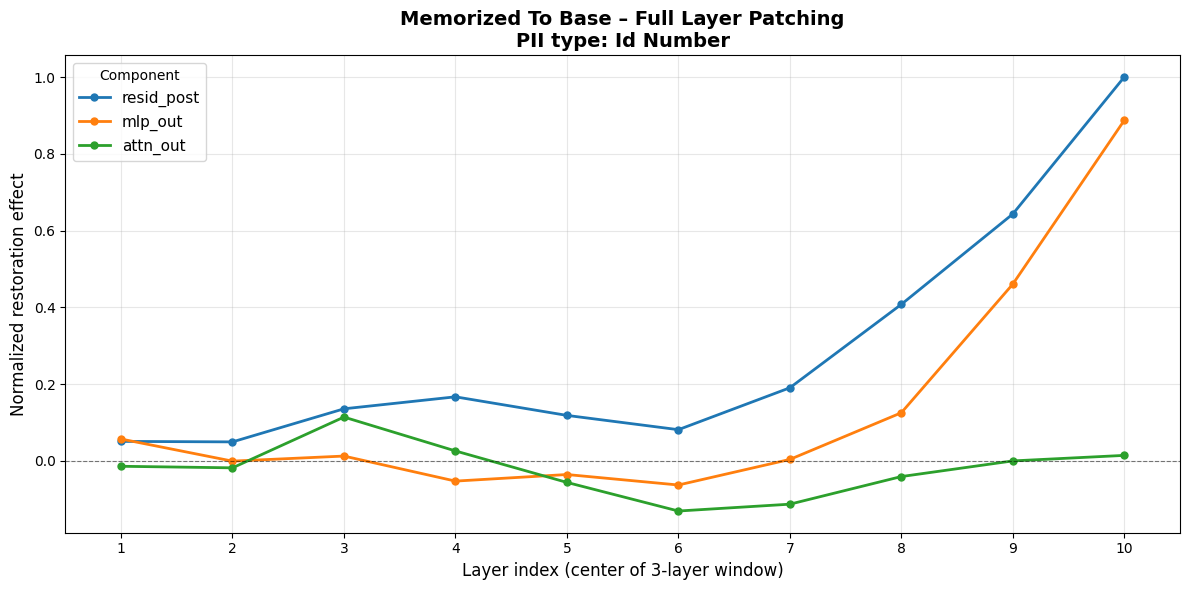

Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/memorized_to_base/v2_layer_sweep_3_layer_window/layer_sweep__pii-passport__components-resid_post-mlp_out-attn_out__ntok-1__run-v2_layer_sweep_3_layer_window.png


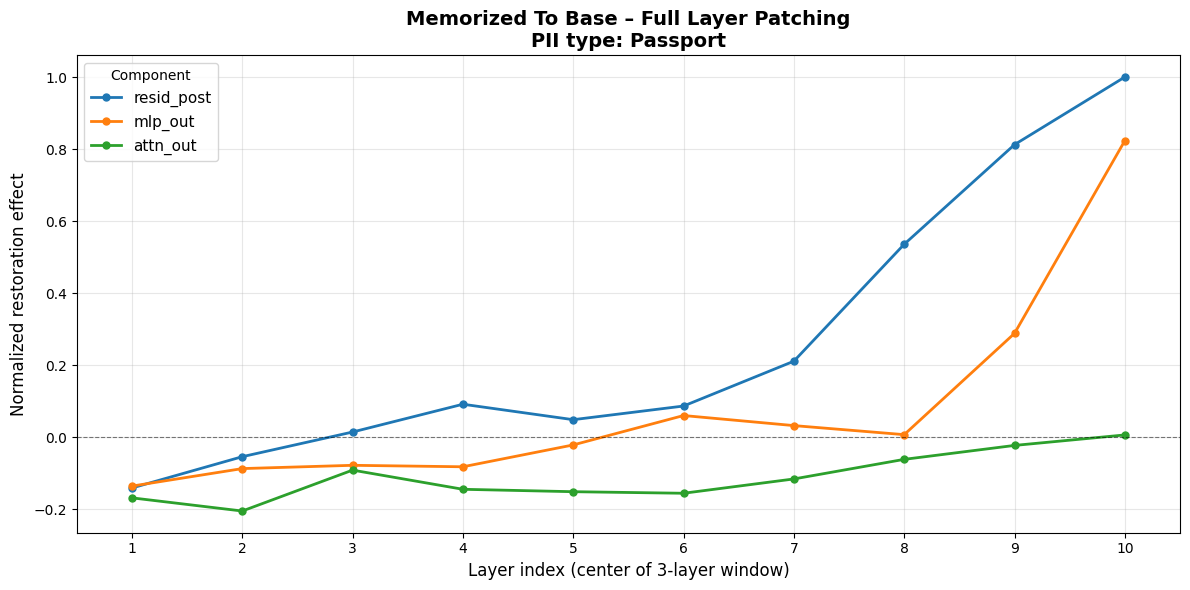

In [309]:
# Sliding-window layer sweep visualization for memorized -> base experiment
RUN_ID_SWEEP_MEM = "v2_layer_sweep_3_layer_window"
PATCH_DIRECTION_SWEEP_MEM = "memorized_to_base"  # matches how results were computed
COMPONENTS_MEM = ["resid_post", "mlp_out", "attn_out"]                       # e.g. ["resid_post", "mlp_out", "attn_out"]

baseline_metrics = compute_baseline_metrics(tl_control_model, tl_target_model, tokenized_pii_data)
results = {}
layer_names = COMPONENTS_MEM
for pii_type, samples in tqdm(tokenized_pii_data.items(), desc="PII type", position=0):
    results[pii_type] = {}
    results[pii_type]["num_target_tokens"] = samples["num_target_tokens"]
    baseline_ctrl_logprob = baseline_metrics[pii_type]["mean_ctrl_logprob"]
    for layer_name in tqdm(layer_names, desc=f"{pii_type} layer name", position=1):
        results[pii_type][layer_name] = patch_layer_activations(
            tl_control_model,
            tl_target_model,
            layer_name,
            samples,
            baseline_metrics,
        )

n_layers = tl_control_model.cfg.n_layers
patched_layer_indices = np.arange(1, n_layers - 1)  # centers of 3-layer windows

# Create one figure per PII type
for pii_type, pii_results in results.items():
    num_target_tokens = pii_results["num_target_tokens"]
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each component as a separate line
    for component in COMPONENTS_MEM:
        improvements = pii_results[component]
        ax.plot(
            patched_layer_indices,
            improvements[patched_layer_indices],
            marker="o",
            label=component,
            linewidth=2,
            markersize=5,
        )

    ax.set_xlabel("Layer index (center of 3-layer window)", fontsize=12)
    ax.set_ylabel("Normalized restoration effect", fontsize=12)

    title = (
        f"{PATCH_DIRECTION_SWEEP_MEM.replace('_', ' ').title()} – Full Layer Patching\n"
        f"PII type: {pii_type.replace('_', ' ').title()}"
    )
    ax.set_title(title, fontsize=14, fontweight="bold")

    ax.legend(title="Component", fontsize=11, loc="best")
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8, alpha=0.5)

    # Set x-axis ticks to show all patched layers
    ax.set_xticks(patched_layer_indices)
    ax.set_xlim(patched_layer_indices[0] - 0.5, patched_layer_indices[-1] + 0.5)

    plt.tight_layout()

    # Save figure with descriptive, config-based filename
    out_dir = OUTPUT_VIS_DIR / PATCH_DIRECTION_SWEEP_MEM / RUN_ID_SWEEP_MEM
    os.makedirs(out_dir, exist_ok=True)

    stem = (
        f"layer_sweep"
        f"__pii-{pii_type}"
        f"__components-{'-'.join(COMPONENTS_MEM)}"
        f"__ntok-{num_target_tokens}"
        f"__run-{RUN_ID_SWEEP_MEM}"
    )

    meta = {
        "run_id": RUN_ID_SWEEP_MEM,
        "patch_direction": PATCH_DIRECTION_SWEEP_MEM,
        "components": ', '.join(COMPONENTS_MEM),
        "pii_type": pii_type,
        "model_name": BASE_MODEL_NAME,
        "model_size_m": MODEL_SIZE,
        "num_target_tokens": int(num_target_tokens),
        "n_layers": int(n_layers),
    }

    for key in meta:
        meta[key] = str(meta[key])

    output_path = (out_dir / stem).with_suffix(".png")
    plt.savefig(output_path, dpi=150, bbox_inches="tight", metadata=meta)
    print(f"Saved figure to: {output_path}")
    plt.show()



From our results above it seems that significant improvement occurs at the later layers (9 & 10) for mlp. The attention layer seems to have no significant effect (or event a slight negative effect) in the improvement.

Patching earlier layers seem to actually have a slight performance negative effect (-10%) on predicting the next target pii token(s) compared to the control

So now lets focus on the layers 9 and 10 for the MLP components

We will compute the improvement for layers 8-12

In [299]:
# Helper function for imshow heatmap (similar to activation-patching-experiments.ipynb)
def imshow(tensor, **kwargs):
    """Simple wrapper around plotly.express.imshow.
    
    Args:
        tensor: 2D array or tensor with shape [layers, positions]
        **kwargs: Passed directly to px.imshow (e.g., x, y, labels, title).
    """
    fig = px.imshow(
        tl_utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    )
    return fig


def hook_fn(activation, hook, cache, pos):
    cached = cache[hook.name]
    patched = activation.clone()
    patched[:, pos, ...] = cached[:, pos, ...]
    return patched

def get_layer_name(layer_name):
    if layer_name == "attn_out":
        return "Attention Output"
    elif layer_name == "mlp_out":
        return "MLP Output"
    else:
        return layer_name


# Configuration for MLP position patching (memorized -> base)
RUN_ID_MLP_POS_MEM = "v2_mlp"
PATCH_DIRECTION_MLP_POS_MEM = "memorized_to_base"
COMPONENT_MLP_POS_MEM = "mlp_out"
TARGET_LAYERS_MLP_POS_MEM = [8, 9, 10, 11]
PII_TYPES_TO_RUN_MLP_POS_MEM = PII_TYPES  # or a subset like ["email"]

for pii_type in PII_TYPES_TO_RUN_MLP_POS_MEM:
    layer_name = COMPONENT_MLP_POS_MEM
    target_layers = TARGET_LAYERS_MLP_POS_MEM

    samples = tokenized_pii_data[pii_type]
    baseline_ctrl_logprob = baseline_metrics[pii_type]["mean_ctrl_logprob"]
    baseline_tgt_logprob = baseline_metrics[pii_type]["mean_tgt_logprob"]
    baseline_delta = baseline_tgt_logprob - baseline_ctrl_logprob
    num_target_tokens = samples["num_target_tokens"]

    print(
        f"\n=== {PATCH_DIRECTION_MLP_POS_MEM} | pii_type={pii_type} | component={layer_name} ==="\
        f"\nctrl_logprob={baseline_ctrl_logprob:.4f}, tgt_logprob={baseline_tgt_logprob:.4f}, delta={baseline_delta:.4f}"
    )

    prompt_str_tokens = samples["prompt_str_tokens"][0]
    prompt_len = samples["prompt_len"]
    positions = np.arange(prompt_len)

    # Run target model once to get cache
    full_tokens = torch.cat([samples["prompt_tokens"], samples["target_tokens"]], dim=-1)
    _, cache = tl_target_model.run_with_cache(full_tokens, return_cache_object=True)

    # Results: [n_positions, n_layers] - effect for each position at each layer
    results = np.zeros((prompt_len, len(target_layers)), dtype=np.float32)

    # Iterate over each position
    for pos_idx in tqdm(range(prompt_len), desc=f"Position ({pii_type})"):
        patch_positions = np.array([pos_idx])  # Patch only this position

        # Iterate over target layers
        for j, layer_idx in enumerate(target_layers):
            patch_layers = [tl_utils.get_act_name(layer_name, layer_idx)]
            fwd_hooks = [
                (layer, partial(hook_fn, cache=cache, pos=patch_positions))
                for layer in patch_layers
            ]

            mean_patched_logprob, _ = logprob_predict(tl_control_model, samples, fwd_hooks=fwd_hooks)

            # Normalized restoration effect
            normalized_improvement = (mean_patched_logprob - baseline_ctrl_logprob) / baseline_delta
            results[pos_idx, j] = normalized_improvement

    # Create visualization as heatmap
    # Transpose results from [n_positions, n_layers] to [n_layers, n_positions]
    improvement_matrix = results.T  # Shape: [n_layers, n_positions]

    # Create position labels with str_tokens
    prompt_position_labels = [f"{token}_{i}" for i, token in enumerate(prompt_str_tokens)]

    # Create layer labels
    layer_labels = [f"Layer {layer_idx}" for layer_idx in target_layers]

    # Build descriptive title
    title = (
        f"{PATCH_DIRECTION_MLP_POS_MEM.replace('_', ' ').title()} – {get_layer_name(layer_name)} position patching\n"
        f"PII type: {pii_type.replace('_', ' ').title()}"
    )

    # Create heatmap
    fig = imshow(
        improvement_matrix,
        x=prompt_position_labels,
        y=layer_labels,
        title=title,
        labels={
            "x": "Prompt position / token",
            "y": "Layer index",
            "color": "Effect",
        },
    )

    # Attach metadata for later inspection / paper writing
    meta = {
        "run_id": RUN_ID_MLP_POS_MEM,
        "patch_direction": PATCH_DIRECTION_MLP_POS_MEM,
        "component": layer_name,
        "pii_type": pii_type,
        "model_name": BASE_MODEL_NAME,
        "model_size_m": MODEL_SIZE,
        "target_layers": target_layers,
        "num_target_tokens": int(num_target_tokens),
        "prompt_len": int(prompt_len),
        "tokens": prompt_str_tokens,
        "baseline_ctrl_logprob": float(baseline_ctrl_logprob),
        "baseline_tgt_logprob": float(baseline_tgt_logprob),
    }
    fig.update_layout(meta=meta, title=dict(text=title, x=0.5))

    # Save figure with a descriptive, config-based filename
    out_dir = OUTPUT_VIS_DIR / PATCH_DIRECTION_MLP_POS_MEM / RUN_ID_MLP_POS_MEM
    os.makedirs(out_dir, exist_ok=True)

    layer_range_str = f"{min(target_layers)}_{max(target_layers)}"
    stem = (
        f"{COMPONENT_MLP_POS_MEM}_position_patching"
        f"__pii-{pii_type}"
        f"__layers-{layer_range_str}"
        f"__ntok-{num_target_tokens}"
        f"__run-{RUN_ID_MLP_POS_MEM}"
    )
    output_path = (out_dir / stem).with_suffix(".png")
    fig.write_image(output_path)
    print(f"Saved figure to: {output_path}")

    fig.show()

    print(
        f"Results shape: {results.shape} | "
        f"position range: 0–{prompt_len-1} | "
        f"layers: {target_layers}"
    )



=== memorized_to_base | pii_type=driver_license | component=mlp_out ===
ctrl_logprob=-10.4162, tgt_logprob=-0.1006, delta=10.3156


Position (driver_license):   0%|          | 0/8 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/memorized_to_base/v2_mlp/mlp_out_position_patching__pii-driver_license__layers-8_11__ntok-1__run-v2_mlp.png


Results shape: (8, 4) | position range: 0–7 | layers: [8, 9, 10, 11]

=== memorized_to_base | pii_type=email | component=mlp_out ===
ctrl_logprob=-8.7238, tgt_logprob=-0.0560, delta=8.6678


Position (email):   0%|          | 0/6 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/memorized_to_base/v2_mlp/mlp_out_position_patching__pii-email__layers-8_11__ntok-1__run-v2_mlp.png


Results shape: (6, 4) | position range: 0–5 | layers: [8, 9, 10, 11]

=== memorized_to_base | pii_type=id_number | component=mlp_out ===
ctrl_logprob=-10.5960, tgt_logprob=-0.1698, delta=10.4262


Position (id_number):   0%|          | 0/8 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/memorized_to_base/v2_mlp/mlp_out_position_patching__pii-id_number__layers-8_11__ntok-1__run-v2_mlp.png


Results shape: (8, 4) | position range: 0–7 | layers: [8, 9, 10, 11]

=== memorized_to_base | pii_type=passport | component=mlp_out ===
ctrl_logprob=-7.8805, tgt_logprob=-0.0479, delta=7.8325


Position (passport):   0%|          | 0/7 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/memorized_to_base/v2_mlp/mlp_out_position_patching__pii-passport__layers-8_11__ntok-1__run-v2_mlp.png


Results shape: (7, 4) | position range: 0–6 | layers: [8, 9, 10, 11]


# Effect of "unlearning" patching from control to memorized

Lets try to now see the effect of patching from the base model to the memorized model

Now control model is the memorized one, and target is the base

Loading base model: EleutherAI/pythia-160m
Loading target model from: /Users/georgekontorousis/git/pii_memo/models/160M/base
Loading control model from: /Users/georgekontorousis/git/pii_memo/models/160M/memorized
Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer
Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer


PII type:   0%|          | 0/4 [00:00<?, ?it/s]

driver_license layer name:   0%|          | 0/3 [00:00<?, ?it/s]

email layer name:   0%|          | 0/3 [00:00<?, ?it/s]

id_number layer name:   0%|          | 0/3 [00:00<?, ?it/s]

passport layer name:   0%|          | 0/3 [00:00<?, ?it/s]

Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_layer_sweep_3_layer_window/layer_sweep__pii-driver_license__components-resid_post-mlp_out-attn_out__ntok-1__run-v2_layer_sweep_3_layer_window.png


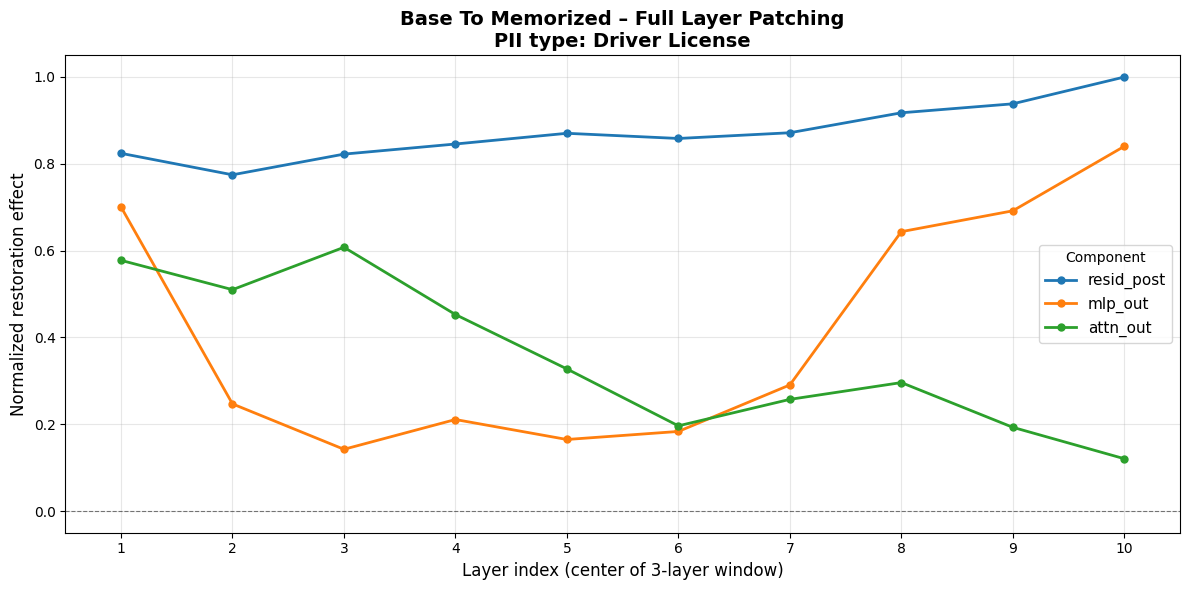

Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_layer_sweep_3_layer_window/layer_sweep__pii-email__components-resid_post-mlp_out-attn_out__ntok-1__run-v2_layer_sweep_3_layer_window.png


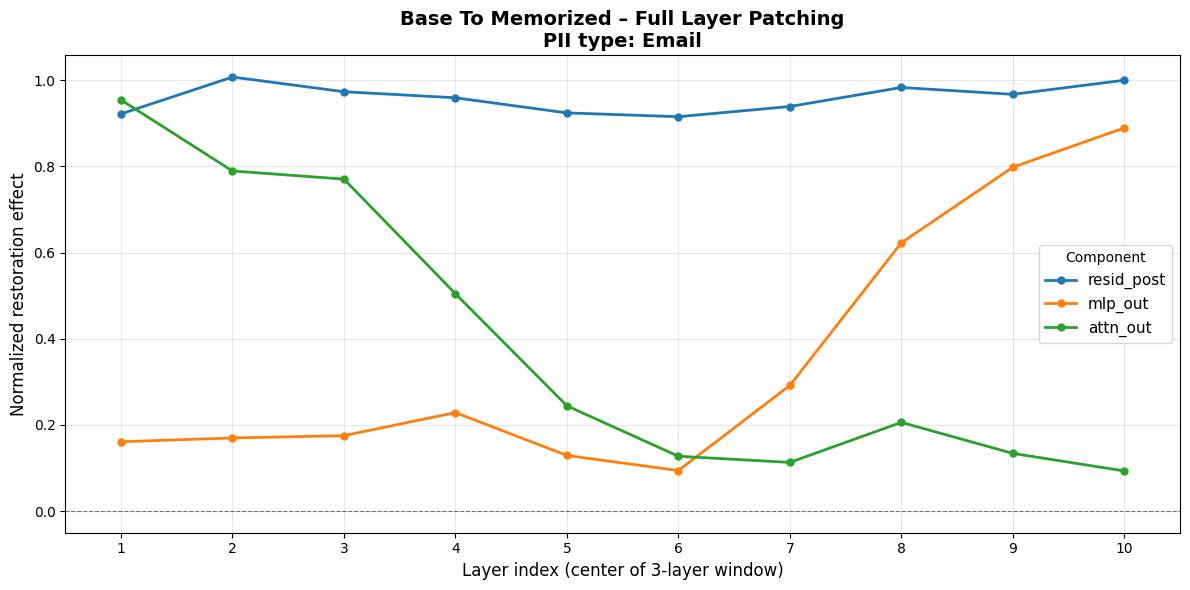

Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_layer_sweep_3_layer_window/layer_sweep__pii-id_number__components-resid_post-mlp_out-attn_out__ntok-1__run-v2_layer_sweep_3_layer_window.png


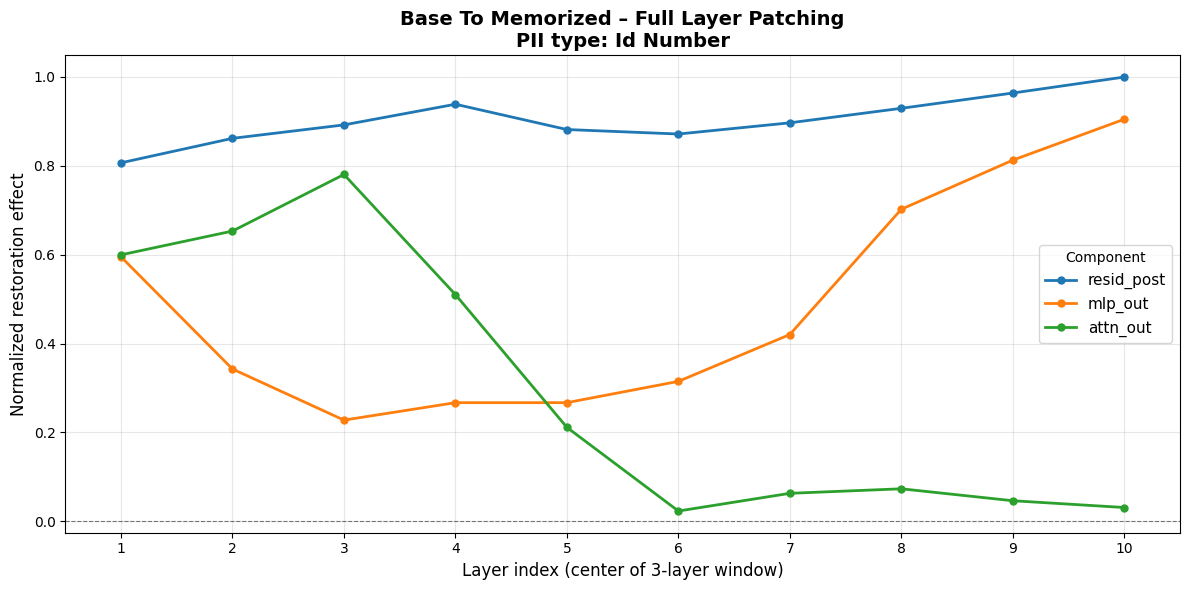

Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_layer_sweep_3_layer_window/layer_sweep__pii-passport__components-resid_post-mlp_out-attn_out__ntok-1__run-v2_layer_sweep_3_layer_window.png


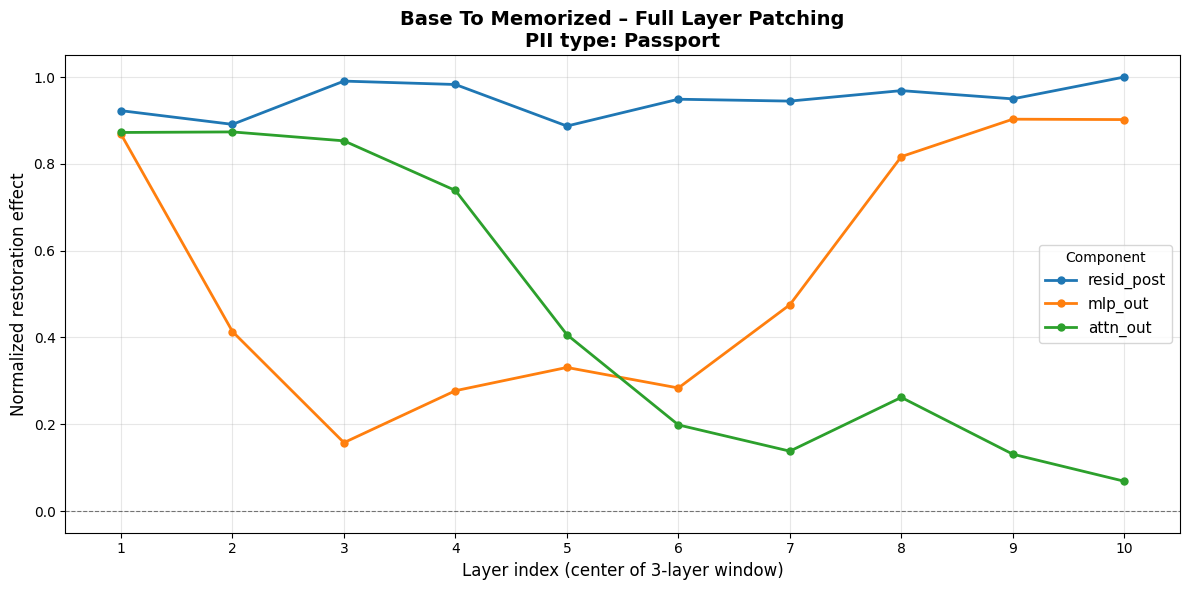

In [ ]:
# Sliding-window layer sweep visualization for base -> memorized experiment
RUN_ID_SWEEP = "v2_layer_sweep_3_layer_window"
PATCH_DIRECTION_SWEEP = "base_to_memorized"  # matches how results were computed
COMPONENTS =  ["resid_post", "mlp_out", "attn_out"]                       # e.g. ["resid_post", "mlp_out", "attn_out"]

# now control model is the memorized one, and target is the base
tl_target_model, tl_control_model, tokenizer = load_pythia_models(
    MODEL_SIZE,
    BASE_MODEL_PATH,
    MEMORIZED_MODEL_PATH,
    DEVICE,
)

baseline_metrics = compute_baseline_metrics(tl_control_model, tl_target_model, tokenized_pii_data)
results = {}
layer_names = COMPONENTS
for pii_type, samples in tqdm(tokenized_pii_data.items(), desc="PII type", position=0):
    results[pii_type] = {}
    results[pii_type]["num_target_tokens"] = samples["num_target_tokens"]
    baseline_ctrl_logprob = baseline_metrics[pii_type]["mean_ctrl_logprob"]
    for layer_name in tqdm(layer_names, desc=f"{pii_type} layer name", position=1):
        results[pii_type][layer_name] = patch_layer_activations(
            tl_control_model,
            tl_target_model,
            layer_name,
            samples,
            baseline_metrics,
        )


n_layers = tl_control_model.cfg.n_layers
patched_layer_indices = np.arange(1, n_layers - 1)  # centers of 3-layer windows

# Create one figure per PII type
for pii_type, pii_results in results.items():
    num_target_tokens = pii_results["num_target_tokens"]
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each component as a separate line
    for component in COMPONENTS:
        improvements = pii_results[component]
        ax.plot(
            patched_layer_indices,
            improvements[patched_layer_indices],
            marker="o",
            label=component,
            linewidth=2,
            markersize=5,
        )

    ax.set_xlabel("Layer index (center of 3-layer window)", fontsize=12)
    ax.set_ylabel("Normalized restoration effect", fontsize=12)

    title = (
        f"{PATCH_DIRECTION_SWEEP.replace('_', ' ').title()} – Full Layer Patching\n"
        f"PII type: {pii_type.replace('_', ' ').title()}"
    )
    ax.set_title(title, fontsize=14, fontweight="bold")

    ax.legend(title="Component", fontsize=11, loc="best")
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8, alpha=0.5)

    # Set x-axis ticks to show all patched layers
    ax.set_xticks(patched_layer_indices)
    ax.set_xlim(patched_layer_indices[0] - 0.5, patched_layer_indices[-1] + 0.5)

    plt.tight_layout()

    # Save figure with descriptive, config-based filename
    out_dir = OUTPUT_VIS_DIR / PATCH_DIRECTION_SWEEP / RUN_ID_SWEEP
    os.makedirs(out_dir, exist_ok=True)

    stem = (
        f"layer_sweep"
        f"__pii-{pii_type}"
        f"__components-{'-'.join(COMPONENTS)}"
        f"__ntok-{num_target_tokens}"
        f"__run-{RUN_ID_SWEEP}"
    )


    meta = {
        "run_id": RUN_ID_SWEEP,
        "patch_direction": PATCH_DIRECTION_SWEEP,
        "components": COMPONENTS,
        "pii_type": pii_type,
        "model_name": BASE_MODEL_NAME,
        "model_size_m": MODEL_SIZE,
        "num_target_tokens": int(num_target_tokens),
        "n_layers": int(n_layers),
    }

    for key in meta:
        meta[key] = str(meta[key])

    output_path = (out_dir / stem).with_suffix(".png")
    plt.savefig(output_path, dpi=150, bbox_inches="tight", metadata=meta)
    print(f"Saved figure to: {output_path}")
    plt.show()



## Examine Attention Heads at Early Layers

From the layer patching sweep we observe that at early layers the attention output has a very significant effect in "forgetting" the target pii when patching from base to memorized

Lets examine this closer with per-head full-layer patching at these early layers

In [ ]:
def attn_head_hook_fn(activation, hook, cache, pos, head_idx):
    cached = cache[hook.name]
    patched = activation.clone()
    patched[:, pos, head_idx, ...] = cached[:, pos, head_idx, ...]
    return patched

# Helper function for imshow heatmap (similar to activation-patching-experiments.ipynb)
def imshow(tensor, **kwargs):
    """Simple wrapper around plotly.express.imshow.
    
    Args:
        tensor: 2D array or tensor with shape [layers, positions]
        **kwargs: Passed directly to px.imshow (e.g., x, y, labels, title).
    """
    fig = px.imshow(
        tl_utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    )
    return fig



RUN_ID = "v2_attn_head_patching"
PATCH_DIRECTION = "base_to_memorized"  # base -> memorized
COMPONENT = "z"
TARGET_LAYERS = [0, 1, 2, 3, 4]
PII_TYPES_TO_RUN = PII_TYPES  # or e.g. ["passport"] to restrict

for pii_type in PII_TYPES_TO_RUN:
    target_layers = TARGET_LAYERS
    samples = tokenized_pii_data[pii_type]
    baseline_ctrl_logprob = baseline_metrics[pii_type]["mean_ctrl_logprob"]
    baseline_tgt_logprob = baseline_metrics[pii_type]["mean_tgt_logprob"]
    baseline_delta = baseline_tgt_logprob - baseline_ctrl_logprob
    num_target_tokens = samples["num_target_tokens"]

    print(f"\n=== {PATCH_DIRECTION} | pii_type={pii_type} | component={layer_name} ===")
    print(
        f"baseline_ctrl_logprob: {baseline_ctrl_logprob:.4f}, "
        f"baseline_tgt_logprob: {baseline_tgt_logprob:.4f}, "
        f"delta: {baseline_delta:.4f}"
    )

    
    positions = np.arange(samples["prompt_len"]) # patch all positions (all input prompt positions)
    n_heads = tl_control_model.cfg.n_heads
    results = np.zeros((n_heads, len(target_layers)))
    
    for head_idx in range(n_heads):
        for layer_idx in target_layers:
            fwd_hooks = [
                (tl_utils.get_act_name('z', layer_idx, 'attn'), partial(attn_head_hook_fn, cache=cache, pos=positions, head_idx=head_idx))
            ]
            mean_patched_logprob, _ = logprob_predict(tl_control_model, samples, fwd_hooks=fwd_hooks)
            normalized_improvement = (mean_patched_logprob - baseline_ctrl_logprob) / baseline_delta
            results[head_idx, layer_idx] = normalized_improvement
    
    # Create visualization as heatmap
    fig = imshow(
        results,
        x=target_layers,
        y=np.arange(n_heads),
        title=f"{PATCH_DIRECTION.replace('_', ' ').title()} – Attention Head Patching\n"
              f"PII type: {pii_type.replace('_', ' ').title()}",
        labels={
            "x": "Layer index",
            "y": "Head index",
            "color": "Effect",
        },
    )

    meta = {
        "run_id": RUN_ID,
        "patch_direction": PATCH_DIRECTION,
        "component": COMPONENT,
        "pii_type": pii_type,
        "model_name": BASE_MODEL_NAME,
        "model_size_m": MODEL_SIZE,
    }
    fig.update_layout(meta=meta)

    # Save figure with a descriptive, config-based filename
    out_dir = OUTPUT_VIS_DIR / PATCH_DIRECTION / RUN_ID
    os.makedirs(out_dir, exist_ok=True)

    stem = (
        f"{COMPONENT}_head_patching"
        f"__pii-{pii_type}"
        f"__layers-{'-'.join(map(str, target_layers))}"
        f"__ntok-{num_target_tokens}"
    )
    output_path = (out_dir / stem).with_suffix(".png")
    fig.write_image(output_path)
    print(f"Saved figure to: {output_path}")

    fig.show()

        
    
    
    


=== base_to_memorized | pii_type=driver_license | component=attn_out ===
baseline_ctrl_logprob: -0.1006, baseline_tgt_logprob: -10.4162, delta: -10.3156


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_attn_head_patching/z_head_patching__pii-driver_license__layers-0-1-2-3-4__ntok-1.png



=== base_to_memorized | pii_type=email | component=attn_out ===
baseline_ctrl_logprob: -0.0560, baseline_tgt_logprob: -8.7238, delta: -8.6678


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_attn_head_patching/z_head_patching__pii-email__layers-0-1-2-3-4__ntok-1.png



=== base_to_memorized | pii_type=id_number | component=attn_out ===
baseline_ctrl_logprob: -0.1698, baseline_tgt_logprob: -10.5960, delta: -10.4262


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_attn_head_patching/z_head_patching__pii-id_number__layers-0-1-2-3-4__ntok-1.png



=== base_to_memorized | pii_type=passport | component=attn_out ===
baseline_ctrl_logprob: -0.0479, baseline_tgt_logprob: -7.8805, delta: -7.8325


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_attn_head_patching/z_head_patching__pii-passport__layers-0-1-2-3-4__ntok-1.png


'blocks.4.attn.hook_z'

## Do Patching by position and layer

Now we have found interesting results for the attention and the mlp layers.

For all but the email pii type, the first MLP layers (sliding window of 3, center at 1) are very important in destroying the patched model ability to predict the target pii token.

For all pii types, patching the first few attention layers seem very good in destroying the logprob of the target pii, with later layers not having an effect


Lets focus on the attn_out layers by position first

In [311]:
# Helper function for imshow heatmap (similar to activation-patching-experiments.ipynb)
def imshow(tensor, **kwargs):
    """Simple wrapper around plotly.express.imshow.
    
    Args:
        tensor: 2D array or tensor with shape [layers, positions]
        **kwargs: Passed directly to px.imshow (e.g., x, y, labels, title).
    """
    fig = px.imshow(
        tl_utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    )
    return fig

def hook_fn(activation, hook, cache, pos):
    cached = cache[hook.name]
    patched = activation.clone()
    patched[:, pos, ...] = cached[:, pos, ...]
    return patched

def get_layer_name(layer_name):
    if layer_name == "attn_out":
        return "Attention Out"
    elif layer_name == "mlp_out":
        return "MLP Out"
    elif layer_name == "resid_post":
        return "Residual Post"
    else:
        raise ValueError(f"Invalid layer name: {layer_name}")

# Configuration for attention position patching
RUN_ID = "v2_attn_pos"
PATCH_DIRECTION = "base_to_memorized"  # base -> memorized
COMPONENT = "attn_out"
TARGET_LAYERS = [0, 1, 2, 3, 4]
PII_TYPES_TO_RUN = PII_TYPES  # or e.g. ["passport"] to restrict

for pii_type in PII_TYPES_TO_RUN:
    layer_name = COMPONENT
    target_layers = TARGET_LAYERS

    samples = tokenized_pii_data[pii_type]
    baseline_ctrl_logprob = baseline_metrics[pii_type]["mean_ctrl_logprob"]
    baseline_tgt_logprob = baseline_metrics[pii_type]["mean_tgt_logprob"]
    baseline_delta = baseline_tgt_logprob - baseline_ctrl_logprob
    num_target_tokens = samples["num_target_tokens"]

    print(f"\n=== {PATCH_DIRECTION} | pii_type={pii_type} | component={layer_name} ===")
    print(
        f"baseline_ctrl_logprob: {baseline_ctrl_logprob:.4f}, "
        f"baseline_tgt_logprob: {baseline_tgt_logprob:.4f}, "
        f"delta: {baseline_delta:.4f}"
    )

    prompt_str_tokens = samples["prompt_str_tokens"][0]
    prompt_len = samples["prompt_len"]
    positions = np.arange(prompt_len)

    # Run target model once to get cache
    full_tokens = torch.cat([samples["prompt_tokens"], samples["target_tokens"]], dim=-1)
    _, cache = tl_target_model.run_with_cache(full_tokens, return_cache_object=True)

    # Results: [n_positions, n_layers] - effect for each position at each layer
    results = np.zeros((prompt_len, len(target_layers)), dtype=np.float32)

    # Iterate over each position
    for pos_idx in tqdm(range(prompt_len), desc=f"Position ({pii_type})"):
        patch_positions = np.array([pos_idx])  # Patch only this position

        # Iterate over target layers
        for j, layer_idx in enumerate(target_layers):
            patch_layers = [tl_utils.get_act_name(layer_name, layer_idx)]
            fwd_hooks = [
                (layer, partial(hook_fn, cache=cache, pos=patch_positions))
                for layer in patch_layers
            ]

            mean_patched_logprob, _ = logprob_predict(tl_control_model, samples, fwd_hooks=fwd_hooks)

            # Normalized effect ("restore" toward base model)
            normalized_improvement = (mean_patched_logprob - baseline_ctrl_logprob) / baseline_delta
            results[pos_idx, j] = normalized_improvement

    # Create visualization as heatmap
    # Transpose results from [n_positions, n_layers] to [n_layers, n_positions]
    improvement_matrix = results.T  # Shape: [n_layers, n_positions]

    # Create position labels with str_tokens
    prompt_position_labels = [f"{token}_{i}" for i, token in enumerate(prompt_str_tokens)]

    # Create layer labels
    layer_labels = [f"Layer {layer_idx}" for layer_idx in target_layers]

    # Build descriptive title
    title = (
        f"{PATCH_DIRECTION.replace('_', ' ').title()} – {get_layer_name(layer_name)} position patching\n"
        f"PII type: {pii_type.replace('_', ' ').title()}"
    )

    # Create heatmap
    fig = imshow(
        improvement_matrix,
        x=prompt_position_labels,
        y=layer_labels,
        title=title,
        labels={
            "x": "Prompt position / token",
            "y": "Layer index",
            "color": "Effect",
        },
    )

    # Attach metadata for later inspection / paper writing
    meta = {
        "run_id": RUN_ID,
        "patch_direction": PATCH_DIRECTION,
        "component": layer_name,
        "pii_type": pii_type,
        "model_name": BASE_MODEL_NAME,
        "model_size_m": MODEL_SIZE,
        "target_layers": target_layers,
        "num_target_tokens": int(num_target_tokens),
        "prompt_len": int(prompt_len),
        "tokens": prompt_str_tokens,
        "baseline_ctrl_logprob": float(baseline_ctrl_logprob),
        "baseline_tgt_logprob": float(baseline_tgt_logprob),
    }
    fig.update_layout(meta=meta, title=dict(text=title, x=0.5))

    # Save figure with a descriptive, config-based filename
    out_dir = OUTPUT_VIS_DIR / PATCH_DIRECTION / RUN_ID
    os.makedirs(out_dir, exist_ok=True)

    layer_range_str = f"{min(target_layers)}_{max(target_layers)}"
    stem = (
        f"{COMPONENT}_position_patching"
        f"__pii-{pii_type}"
        f"__layers-{layer_range_str}"
        f"__ntok-{num_target_tokens}"
        f"__run-{RUN_ID}"
    )
    output_path = (out_dir / stem).with_suffix(".png")
    fig.write_image(output_path)
    print(f"Saved figure to: {output_path}")

    fig.show()

    print(
        f"Results shape: {results.shape} | "
        f"position range: 0–{prompt_len-1} | "
        f"layers: {target_layers}"
    )



=== base_to_memorized | pii_type=driver_license | component=attn_out ===
baseline_ctrl_logprob: -0.1006, baseline_tgt_logprob: -10.4162, delta: -10.3156


Position (driver_license):   0%|          | 0/8 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_attn_pos/attn_out_position_patching__pii-driver_license__layers-0_4__ntok-1__run-v2_attn_pos.png


Results shape: (8, 5) | position range: 0–7 | layers: [0, 1, 2, 3, 4]

=== base_to_memorized | pii_type=email | component=attn_out ===
baseline_ctrl_logprob: -0.0560, baseline_tgt_logprob: -8.7238, delta: -8.6678


Position (email):   0%|          | 0/6 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_attn_pos/attn_out_position_patching__pii-email__layers-0_4__ntok-1__run-v2_attn_pos.png


Results shape: (6, 5) | position range: 0–5 | layers: [0, 1, 2, 3, 4]

=== base_to_memorized | pii_type=id_number | component=attn_out ===
baseline_ctrl_logprob: -0.1698, baseline_tgt_logprob: -10.5960, delta: -10.4262


Position (id_number):   0%|          | 0/8 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_attn_pos/attn_out_position_patching__pii-id_number__layers-0_4__ntok-1__run-v2_attn_pos.png


Results shape: (8, 5) | position range: 0–7 | layers: [0, 1, 2, 3, 4]

=== base_to_memorized | pii_type=passport | component=attn_out ===
baseline_ctrl_logprob: -0.0479, baseline_tgt_logprob: -7.8805, delta: -7.8325


Position (passport):   0%|          | 0/7 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved figure to: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M/visualizations/base_to_memorized/v2_attn_pos/attn_out_position_patching__pii-passport__layers-0_4__ntok-1__run-v2_attn_pos.png


Results shape: (7, 5) | position range: 0–6 | layers: [0, 1, 2, 3, 4]
